# Lab session : Mixture Models

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will apply sklearn's EM on images. You will send only one notebook for both parts.

You have to send the filled notebook named **"GMM_familyname1_familyname2.ipynb"** (groups of 2) by email to *lucca.guardiola@centralesupelec.fr* by November 19, 2020 and put **"AML-GMM"** in the subject. 

We begin with the standard imports:

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from scipy.stats import norm
from sklearn.cluster import KMeans
import random
from itertools import compress

# GMM Recap

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. 

### If you want to directly go into the code skip the 2 following sections and implement the Update rules

## Context

Let $X$ be a continous random variable that you have observed, it would be nice to estimate the parameters $\theta$ of the theoretical pdf of x i.e $f_X(x;\theta) = p(x|\theta)$. For instance $\theta$ could be a mean or a variance or $f_x$ could be parametrized by many other parameters. To facilitate the estimation of $\theta$ one could introduces latent variables or hidden variables $Y$ which explains X. 

Introducing a latent variable Y which can take K different values one could write $p(x|\theta)$ as a mixture of K distributions : 
$$ p(x|\theta) = \sum_{k=1}^Kp(x,y=y_k|\theta)=\sum_{k=1}^K p(y=y_k|\theta)p(x|y=y_k,\theta)= \sum_{k=1}^K \pi_kf_k(x;\theta_k) $$

## Basic Exemple 

Imagine you are observing the weight of the french population, and you want the theoretical distribution of the weight $f_X(x;\theta)$. You could introduce the sex of the person (discrete latent variable) or the height of the person (continuous latent variable), these 2 latent variables have a deep impact on the weight of the person. We will be looking at the case where Y is discrete.

Let X be the random variable related to the weight of a french person and Y be the sex of the person the pdf of X is given by : 

$$p(x|\theta) = \pi f_1(x)+(1-\pi)f_2(x)$$

$\pi$ is probability to be a man in France, $f_1(x)$ and $f_2(x) $ are respectively the density function of the men's weight and the pdf of the women's weight.

Now we have to estimate $\pi$ and the parameters of $f_1(x)$ and of $f_2(x)$. 

With GMM we assume that $f_k(x;\theta_k)= \mathcal{N}(x |\mu_k,\sigma_k^2)$. Therefore we need to estimate from the observation of X : $\pi,\mu_1,\sigma_1^2,\mu_2,\sigma_2^2$ such as :

$$p(x|\theta) = \pi \mathcal{N}(x |\mu_1,\sigma_1^2)+(1-\pi)\mathcal{N}(x |\mu_2,\sigma_2^2) $$




We generate a fake weight distribution. The EM algorithm will allow us to estimate the parameters of this probability distribution.

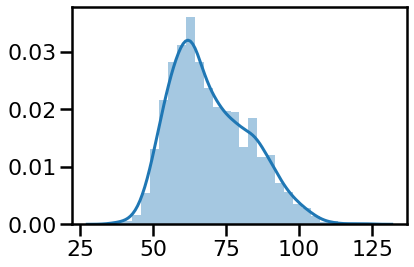

In [87]:
weights = np.append(np.random.normal(60,7,1000),np.random.normal(79,12,1000))
sex = [0 for k in range(1000)]+[1 for k in range(1000)]
sns.distplot(weights)


# EM algorithm 

Em algorithm looks for the parameters $\theta$ maximising :

$$E\left[\mathcal{L}(X_1,...X_N,Y_1,...,Y_N|\theta)|x_1,...x_N,\theta_j\right]= \sum_{i=1}^n \sum_{k=1}^K  \gamma_{i,k}^j \left[ \log(\pi_k) + \log \mathcal{N}(x |\mu_k,\sigma_k^2) \right] == Q(\theta,\theta^j)$$ 

## Update Rules 

Suppose you decide to model your observations $\{x_1,...x_N\}$ with a mixture of K gaussian distributions.

The update rules given by the EM algorithm are at iteration j+1, $k \in \{1,...,K\}$ : 

\begin{align} \gamma_{i,k}^j &= \frac{\pi_k^jf_k(x_i;\theta_k^j)}{\sum_{k=1}^K\pi_k^jf_k(x_i;\theta_k^j)} \\
\pi_k^{j+1} &= \frac{1}{N} \sum_{i=1}^N \gamma_{i,k}^j \\
 (\sigma_k^2)^{j+1}&= \frac{\sum_{i=1}^N (x_i-\mu_k^j)^2\gamma_{i,k}^j}{\sum_{i=1}^N \gamma_{i,k}^j} \\
\mu_k^{j+1}  &= \frac{\sum_{i=1}^N x_i\gamma_{i,k}^j}{\sum_{i=1}^N \gamma_{i,k}^j}
\end{align}

With $\gamma_{i,k}^j = P(Y_i=k|x_i,\theta^j)$ i.e the probability of the data $x_i$ to belong to the class k.

With $f_k(x_i;\theta_k^j) = \mathcal{N}\left(x_i | \mu_k^{j} , (\sigma_k^2)^{j}\right) $

# Task :

- Fill in the following class to implement a 1D-GMM 
- Initialize with Kmeans or with random parameters.

In [88]:
class my_GMM():
    
    def __init__(self, k, nb_iter,initialization):
        '''
        Attributes:
        
        k_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        self.nb_iter_=nb_iter
        self.k_ = k
        self.initialization_ = initialization
        self.mu_ = None
        self.sigma_ = None
        self.pi_ = None
        self.gamma_ = None
        self.labels_ = None
        
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        """
        
        def compute_condition_prob_matrix(X, mu, Sigma):
            
            '''Compute the conditional probability matrix 
            shape: (n, K) i.e p(x|y=k). Use scipy.stats.norm.pdf
            '''
            condition_prob = [] #the n x K matrix
            
            for x in X:
                #for each observation
                prob_classes = [] #one line in the data matrix X
                for i in range(self.k_):
                    proba = norm.pdf(x,mu[i],np.sqrt(Sigma[i])) #we compute proba of x belonging to f_k
                    prob_classes.append(proba)
                condition_prob.append(prob_classes)
            return condition_prob
            
        
        def compute_responsabilities(Condition_prob,pi):
            
            
            '''Compute the responsabilities i.e gamma
            shape: (n, K)
            '''
            gamma = []
            
            for i in range(len(X)):
                #for each observation
                responsabilities = []
                sum_cond_proba = 0
                for j in range(self.k_):
                    #we compute the total sum of conditional probabilities for that specific x
                    sum_cond_proba+=pi[j]*Condition_prob[i][j]
                
                for j in range(self.k_):
                    #we compute the responsability of each class for that specific x
                    responsabilities.append((pi[j]*Condition_prob[i][j])/sum_cond_proba)
                gamma.append(responsabilities)

            return gamma
            

        # TODO:
        # initialize the parameters
        # if initialize_ is kmeans, apply sklearn kmeans 
        # else randomly initialize them
        
        # While not(convergence)
        #     Compute gamma
        #     Update parameters
        
        # Update labels_
        
        init_labels = []
        if self.initialization_ == 'random':
            for x in range(X.shape[0]):
                #we assign random label from range 0 up to K
                init_labels.append(random.randrange(self.k_))
        else:
            kmeans = KMeans(n_clusters=self.k_).fit(X.reshape(-1, 1))
            init_labels = kmeans.labels_.copy()
            
        #now we compute the parameters
        mu = []
        sigma = []
        pi = []
        for i in range(self.k_):
            #for each class in the data
            subset_data = []
            for j in range(len(init_labels)):
                if init_labels[j] == i:
                    #we get the appropriate data
                    subset_data.append(X[j])
            #boolean_list = [True if label==i else False for label in init_labels]
            #subset_data = list(compress(X.shape[:], boolean_list)) #getting the data whose class = i
            mu.append(np.mean(subset_data)) #get the mean for class i
            sigma.append(np.var(subset_data)) #get the variance for class i
            pi.append(len(subset_data)/len(init_labels))
        
        gamma = compute_responsabilities(compute_condition_prob_matrix(X, mu, sigma),pi)
        
        number_iter = 0    
        
        while number_iter < self.nb_iter_:
            
            # first, we compute the sum of the responsabilities for each class
            # that will be used to update pi, sigma and mu
            sum_each_class = np.zeros(self.k_)
            for g in gamma:
                for i in range(self.k_):
                    sum_each_class[i]+=g[i]
            #print(sum_each_class)
            
            # updating pi
            pi = sum_each_class/len(X)
            
            # updating sigma
            sum_for_sigma = np.zeros(self.k_)
            for i in range(len(X)):
                for j in range(self.k_):
                    sum_for_sigma[j] += ((X[i]-mu[j])**2)*gamma[i][j]
            sigma = sum_for_sigma/sum_each_class
            
            #updating mu
            sum_for_mu = np.zeros(self.k_)
            for i in range(len(X)):
                for j in range(self.k_):
                    sum_for_mu[j] += X[i]*gamma[i][j]
            mu = sum_for_mu/sum_each_class
            #print(mu)
            
            gamma = compute_responsabilities(compute_condition_prob_matrix(X, mu, sigma),pi)
            
            number_iter+=1
            if number_iter%10 == 0:
                print('iteration n°',number_iter)
        
        # we are done iterating
        # we save the parameters of the object
        
        self.mu_ = mu
        self.gamma_ = gamma
        self.sigma_ = sigma
        self.pi_ = pi
       
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        # TODO
        prob_classes = [] #one line in the data matrix X
        for i in range(self.k_):
            proba = norm.pdf(X,self.mu_[i],np.sqrt(self.sigma_[i])) #we compute proba of x belonging to f_k
            prob_classes.append(proba)
        return np.argmin(prob_classes)
        
    def predict_proba(self, X):
        """ Predict probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        # TODO
        prob_classes = [] #one line in the data matrix X
        for i in range(self.k_):
            proba = norm.pdf(X,self.mu_[i],np.sqrt(self.sigma_[i])) #we compute proba of x belonging to f_k
            prob_classes.append(proba)
        return prob_classes

## Task : 

Apply you EM algorithm to the weights array.

What is the average weight for a man ? What is the average weight for a woman ? 
What are the standard deviations ? 

In [89]:
#TODO
GMM = my_GMM(2, 200,'kmeans')
GMM.fit(weights)

iteration n° 10
iteration n° 20
iteration n° 30
iteration n° 40
iteration n° 50
iteration n° 60
iteration n° 70
iteration n° 80
iteration n° 90
iteration n° 100
iteration n° 110
iteration n° 120
iteration n° 130
iteration n° 140
iteration n° 150
iteration n° 160
iteration n° 170
iteration n° 180
iteration n° 190
iteration n° 200


In [90]:
print('average weights per group',GMM.mu_)
print('average standard deviation per group',np.sqrt(GMM.sigma_))
print('average proportion per group',GMM.pi_)

average weights per group [59.82184387 78.66345749]
average standard deviation per group [ 6.63086679 11.85033367]
average proportion per group [0.48445475 0.51554525]


# Task :
- Predict the sex of the persons thanks to their weight. 
- Compute the accuracy (the ground truth is the sex list)
- Compare with the accuracy of a kmeans

In [91]:
true_labels = sex.copy()
pred_labels = []

#getting predictions for each weight
for weight in weights:
    pred_labels.append(GMM.predict(weight))
    
#computing accuracy
number_correct_pred = 0
for i in range(len(weights)):
    if pred_labels[i] == true_labels[i]:
        number_correct_pred+=1
        
print('accuracy of GMM:',number_correct_pred/len(true_labels))

#getting labels from a kmeans algorithm
kmeans = KMeans(n_clusters=GMM.k_).fit(weights.reshape(-1, 1))
number_correct_pred = 0
for i in range(len(weights)):
    if kmeans.labels_[i] == true_labels[i]:
        number_correct_pred+=1
        
print('accuracy of Kmeans:',number_correct_pred/len(true_labels))

accuracy of GMM: 0.1565
accuracy of Kmeans: 0.84


## Application - Generating Images

The goal of this exercice is to make your computer learn how to write digits.

Actually we are going to apply EM algorithm to digits and sample fake data from the model returned (i.e $p(x|\theta)$)

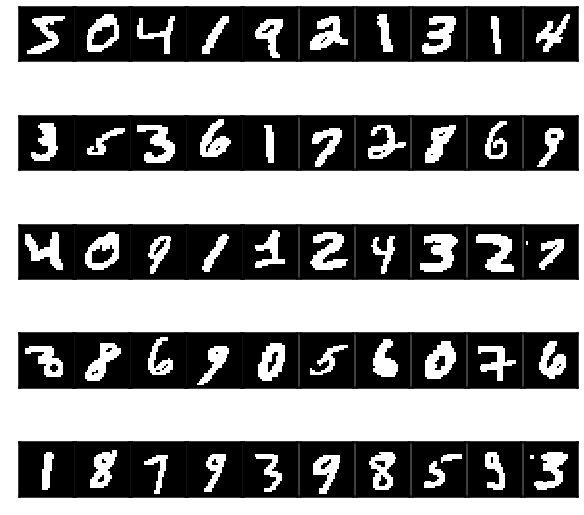

In [92]:
data = np.loadtxt('mnist2500_X.txt')


import matplotlib.pyplot as plt
from sklearn.decomposition import NMF


def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(10, 10),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.01, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(28, 28).T, cmap='binary')
        #im.set_clim(0, )
plot_digits(data)

### Tasks : 
- Model your data with the GMM model from sklearn and produce new synthetic handwritten numbers. 
Use : 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

use the .sample() method from sklearn's GaussianMixture to generate fake samples


### Tasks :
- Use a method you saw in your previous courses to reduce the dimension of our dataset.
- Model your data with the GMM model from sklearn and produce new synthetic handwritten numbers. 
- Compare results

For dimentionality reduction, we will use the NMF decomposition to reduce the dimentionality space from 784 (28x28) to n, where the n is the dimentionality of the reduced matrices. We will parametrize n by using the elbow method, where we will attempt to find an equilibrium between the number of components and the reconstruction error. 

Let's then plot the number of components by their error.

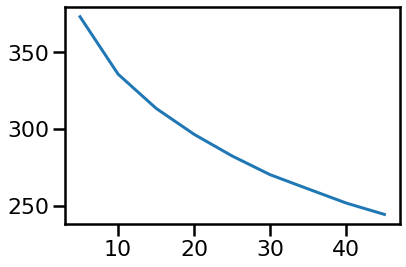

In [93]:
n_components = np.arange(5, 46, 5)
all_models = [NMF(n_components=n, init='random', max_iter=4000).fit(data) for n in n_components]
errors = [model.reconstruction_err_ for model in all_models]
plt.plot(n_components, errors)

From our analysis, we can see that the curve is starting to flatten out. We can infer that a model with around 40 components strikes a good equilibrium between having not too many dimensions while still having a reasonable reconstruction error. 

In [97]:
model = NMF(n_components=40, init='random', max_iter=4000)
W_nmf = model.fit_transform(data) 
H_nmf = model.components_

Now that we have generated our data in a lower dimention (in W_nmf), we will work with scikit's GaussianMixture in order to generate a statistical model for our data that we can then sample for generating the images.

We can also tune this model by the number of components, in order to try to strike the maximal amount of information from our data. We will use the AIC metric to compare these models with different parameters.

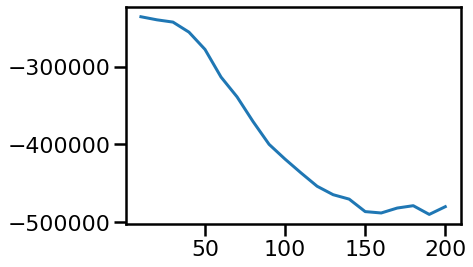

In [98]:
n_components = np.arange(10, 201, 10)
all_models = [GaussianMixture(n_components=n).fit(W_nmf) for n in n_components]
errors = [model.aic(W_nmf) for model in all_models]
plt.plot(n_components, errors)

Finally, we obtain the final amount of components for our Gaussian model of about 160, where the elbow ends and it finds a rather steep plateau.

In [100]:
from sklearn.mixture import GaussianMixture

GMM = GaussianMixture(n_components=160)
GMM.fit(W_nmf)

GaussianMixture(n_components=160)

For image reconstruction, we sample the Gaussian Mixture Model in order to obtain a matrix in the W space of our NMF model. We then multiply this sampled W matrix by the H.

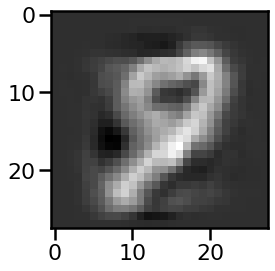

In [112]:
sampled_num = GMM.sample()
reconstruct = np.matmul(sampled_num[0], H_nmf)
plt.imshow(reconstruct.reshape(28,28).T, cmap='binary')

Although we can see the number, we can improve this output by setting a threshold using set_clim for our output.

We will run an experiment incrementing clim from 0.1 to 1 by 0.1 each time.

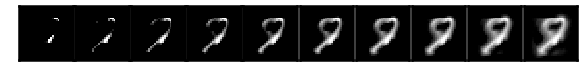

In [115]:
fig, ax = plt.subplots(1, 10, figsize=(10, 10), subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(hspace=0.01, wspace=0.05)
clim_upper_bound = np.arange(0.1, 1.1, 0.1)

for i, axi in enumerate(ax.flat):
    reconstruct = np.matmul(sampled_num[0], H_nmf)
    im = axi.imshow(reconstruct.reshape(28, 28).T, cmap='binary')
    im.set_clim(0, clim_upper_bound[i])

As it can be seen, choosing a clim upper bound of about 0.5 allows for a middle ground between the sharpness of the generated number, while also avoiding "cutting off" parts of the number.

Thus, for the final result we have:

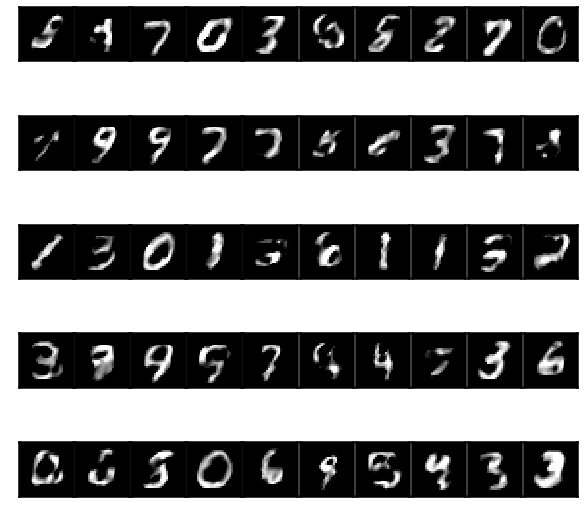

In [128]:
def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(10, 10),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.01, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        reconstruct = np.matmul(data[i], H_nmf)
        im = axi.imshow(reconstruct.reshape(28, 28).T, cmap='binary')
        im.set_clim(0, 0.5)
        
sampled_data = GMM.sample(50)
plot_digits(sampled_data[0])

While the images can look noisy (since they are not, after all, the 0-1 mapping in the original data plot), the individual numbers are quite easily distinguishable. Likewise, they look like handwritten numbers with considerable variance even in the technique used for some of them (look the different angles and shapes of 3s, for example)

This proves that by leveraging dimentionality reduction and gaussian mixture models, we can model and even synthesize image data successfully.